In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches
from matplotlib import ticker
import joblib
from glob import glob
import sys
from credit_pipeline import training, evaluate

sys.path.append("../scripts")
from experiments import load_split, PROTECTED_ATTRIBUTES

# small fix to be able to load models
from credit_pipeline.training import EBE


In [67]:
def summarize_credit_experiment(dataset_name, seed = 0):
    """Function that summarizes the results of the credit models experiment.
    It will print the mean and standard deviation of the metrics and fairness metrics.
    """

    path_1 = "../results/fair_models"
    path_2 = "../results/credit_models"
    df_metrics_val = []
    df_metrics_test = []
   
    for fold in range(10):
        model_dict = {}
        X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
            dataset_name, fold, seed
        )

        # It was necessary to compute the pipeline again due to pickle error
        if dataset_name == "homecredit":
            pipeline_preprocess = training.create_pipeline(X_train, Y_train, crit=4)
        else:
            pipeline_preprocess = training.create_pipeline(X_train, Y_train)
        pipeline_preprocess.fit(X_train, Y_train)
        X_train_preprocessed = pipeline_preprocess.transform(X_train)
        X_val_preprocessed = pipeline_preprocess.transform(X_val)
        A_val = X_val_preprocessed[PROTECTED_ATTRIBUTES[dataset_name] + "_0"]
        X_test_preprocessed = pipeline_preprocess.transform(X_test)
        A_test = X_test_preprocessed[PROTECTED_ATTRIBUTES[dataset_name] + "_0"]

        models_files_1 = glob(f"{path_1}/{dataset_name}/{fold}/*.pkl")
        models_files_1 = [file for file in models_files_1 if "study" not in file]
        models_files_2 = glob(f"{path_2}/{dataset_name}/{fold}/*.pkl")
        models_files_2 = [file for file in models_files_2 if "study" not in file]
        models_files = models_files_1 + models_files_2
    

        class Thr_helper:
            def __init__(self, model, sensitive_features):
                self.model = model
                self.sensitive_features = sensitive_features

            def predict(self, X):
                return self.model.predict(
                    X, sensitive_features=self.sensitive_features
                )

        for file in models_files:
            if file.find("thr") != -1:
                continue
            model = joblib.load(file)
            model_name = file.split("/")[-1].split(".")[0]
            Y_train_pred = model.predict_proba(X_train)[:, 1]
            threshold = training.ks_threshold(Y_train, Y_train_pred)
            model_dict[model_name] = [model, threshold]

        val_metrics = evaluate.get_fairness_metrics(model_dict, X_val, Y_val, A_val)
        val_metrics["fold"] = fold
        test_metrics = evaluate.get_fairness_metrics(model_dict, X_test, Y_test, A_test)
        test_metrics["fold"] = fold
        
        df_metrics_val.append(val_metrics)
        df_metrics_test.append(test_metrics)
        

        # Threshold Optimizer needs a different procedure as it does not predict probabilities
        for file in models_files:
            if file.find("thr") == -1:
                continue

            model = joblib.load(file)
            model_name = file.split("/")[-1].split(".")[0]
            thr_opt_helper_val = Thr_helper(model, A_val)
            thr_opt_helper_test = Thr_helper(model, A_test)
            model_dict = {model_name: [thr_opt_helper_val, None]}
            val_metrics = evaluate.get_fairness_metrics(
                model_dict, X_val_preprocessed, Y_val, A_val
            )
            val_metrics["fold"] = fold
            model_dict = {model_name: [thr_opt_helper_test, None]}
            test_metrics = evaluate.get_fairness_metrics(
                model_dict, X_test_preprocessed, Y_test, A_test
            )
            test_metrics["fold"] = fold
            df_metrics_val.append(val_metrics)
            df_metrics_test.append(test_metrics)

    df_metrics_val = pd.concat(df_metrics_val)
    df_metrics_test = pd.concat(df_metrics_test)

    # apply abs to numerical columns
    num_columns = df_metrics_val.select_dtypes(include=[np.number]).columns
    df_metrics_val[num_columns] = df_metrics_val[num_columns].abs()
    df_metrics_test[num_columns] = df_metrics_test[num_columns].abs()
    df_metrics_val = df_metrics_val.groupby("model").agg("mean").reset_index()
    df_metrics_test = df_metrics_test.groupby("model").agg("mean").reset_index()
    return df_metrics_val, df_metrics_test


In [86]:
def parallel_coordinates(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(1, len(columns)-1, sharey=False, figsize=(15,5))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]

    if columns_tick_format is None:
        columns_tick_format = [None for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    x = list(range(len(columns)))
    axx = axes[-1].twinx()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
        for idx in norm_df.index:
            axx.plot(x, norm_df.loc[idx, columns], c = "blue", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(x, df_value.loc[idx, columns], alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_xlim([x[i], x[i+1]])
        ax.set_ylim([-0.05, 1.05])
        # get yticks from ax
        yticks = ax.get_yticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        if format_ is None:
            ax.set_yticklabels([np.round(yi * col_range  + col_min, 1)  for yi in yticks], fontsize = 18)
        else:
            ax.set_yticklabels([format_(yi * col_range  + col_min)  for yi in yticks], fontsize = 18)
        #ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    axes[0].set_ylim([-0.05, 1.05])

    for i, ax in enumerate(axes[:-1]):
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.set_xticklabels([columns_names[i]], fontsize = 18)

    axes[-1].xaxis.set_major_locator(ticker.FixedLocator([i+1, i+2]))
    axes[-1].set_xticklabels([columns_names[i+1], columns_names[i+2]], fontsize = 18)

    # tick for right side of last axis
    yticks = axes[-1].get_yticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_yticklabels([np.round((yi * col_range +  col_min), 1)  for yi in yticks], fontsize = 18)
    else:
        axx.set_yticklabels([format_(yi * col_range +  col_min)  for yi in yticks], fontsize = 18)
    axx.set_axisbelow(True)
    axx.set_ylim([-0.05, 1.05])
    axx.spines['top'].set_visible(False)
    axx.spines['bottom'].set_visible(False)

    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)
    handles = [
        mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
    ]
    plt.legend(handles = handles, bbox_to_anchor=(1.45, 1.2), loc='upper left', fontsize = 18)

In [97]:
legend_order = [
    "LogisticRegression",
    "MLPClassifier",
    "RandomForestClassifier",
    "LGBMClassifier",
    "rw_LogisticRegression",
    "rw_MLPClassifier",
    "rw_RandomForestClassifier",
    "rw_LGBMClassifier",
    "DemographicParityClassifier",
    "EqualOpportunityClassifier",
    "FairGBMClassifier",
    "thr_LogisticRegression",
    "thr_MLPClassifier",
    "thr_RandomForestClassifier",
    "thr_LGBMClassifier",
]
legends_order_hm = legend_order.copy()
legends_order_hm.remove("DemographicParityClassifier")
legends_order_hm.remove("EqualOpportunityClassifier")

name_mapper = {
    "LogisticRegression" : "LR",
    "MLPClassifier" : "MLP",
    "RandomForestClassifier" : "RF",
    "LGBMClassifier" : "LGBM",
    "rw_LogisticRegression" : "LR_rw",
    "rw_MLPClassifier" : "MLP_rw",
    "rw_RandomForestClassifier" : "RF_rw",
    "rw_LGBMClassifier" : "LGBM_rw",
    "DemographicParityClassifier" : "DemoPar",
    "EqualOpportunityClassifier" : "EqOp",
    "FairGBMClassifier" : "FairGBM",
    "thr_LogisticRegression" : "LR_thr",
    "thr_MLPClassifier" : "MLP_thr",
    "thr_RandomForestClassifier" : "RF_thr",
    "thr_LGBMClassifier" : "LGBM_thr",
}

color_mapper = {
    "LogisticRegression" : "#fdbe85",
    "MLPClassifier" : "#fd8d3c",
    "RandomForestClassifier" : "#e6550d",
    "LGBMClassifier" : "#a63603",
    "rw_LogisticRegression" : "#cbc9e2",
    "rw_MLPClassifier" : "#9e9ac8",
    "rw_RandomForestClassifier" : "#756bb1",
    "rw_LGBMClassifier" : "#54278f",
    "DemographicParityClassifier" : "#92c5de",
    "EqualOpportunityClassifier" : "#0571b0",
    "FairGBMClassifier" : "#f1b6da",
    "thr_LogisticRegression" : "#bae4b3",
    "thr_MLPClassifier" : "#74c476",
    "thr_RandomForestClassifier" : "#31a354",
    "thr_LGBMClassifier" : "#006d2c",
}
columns_tick_format = [
    lambda x : f"{x:.2f}",
    lambda x : f"{x:.2f}",
    lambda x : f"{x:.2f}",
    lambda x : f"{x:.2f}",
    lambda x : f"{x:.2f}",
    lambda x : f"{x:.2f}"
]

In [98]:
_, df_metrics_test = summarize_credit_experiment("german", seed=0)

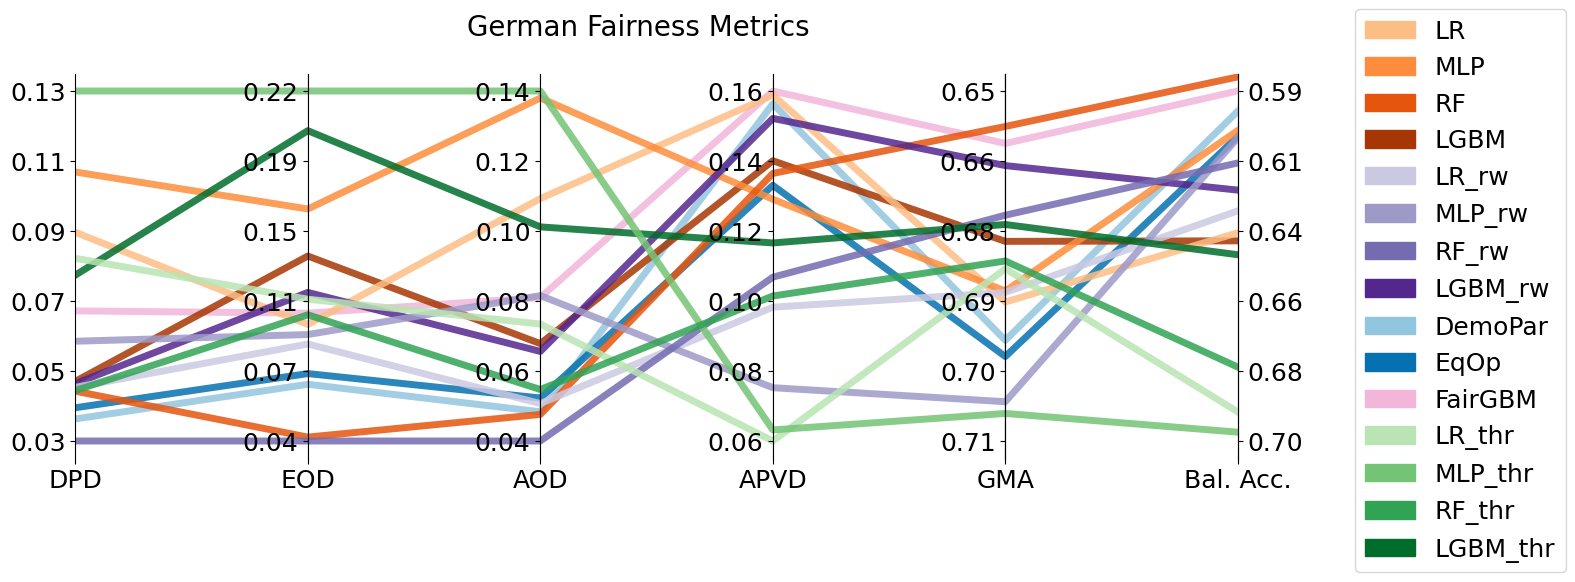

In [99]:
parallel_coordinates(
    df = df_metrics_test,
    columns = [
        'DPD',
        'EOD',
        'AOD',
        'APVD',
        'GMA',
        'balanced_accuracy',
    ],
    columns_ranges = [None, None, None, None, [0.715, 0.65], [0.705, 0.59]],
    columns_tick_format = columns_tick_format,
    columns_names = [
        'DPD',
        'EOD',
        'AOD',
        'APVD',
        'GMA',
        'Bal. Acc.',
    ],
    color_column = "model",
    color_mapper = color_mapper,
    name_mapper = name_mapper,
    legend_order = legend_order,
    title = "German Fairness Metrics"
)
plt.savefig("german_fairness_metrics.pdf", bbox_inches = "tight", dpi=300)

In [100]:
_, df_metrics_test = summarize_credit_experiment("taiwan", seed=0)

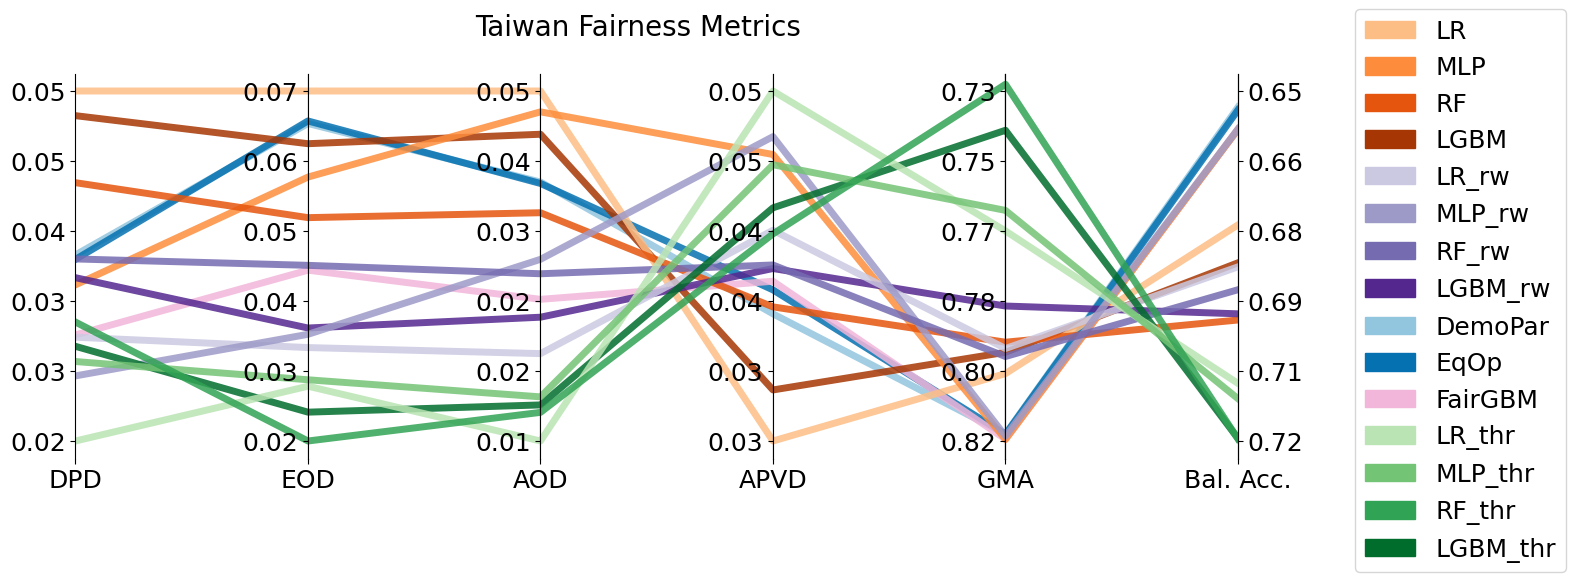

In [102]:
parallel_coordinates(
    df = df_metrics_test,
    columns = [
        'DPD',
        'EOD',
        'AOD',
        'APVD',
        'GMA',
        'balanced_accuracy',
    ],
    columns_ranges = [None, None, None, None, [0.82, 0.73], [0.72, 0.65]],
    columns_tick_format =  columns_tick_format,
    columns_names = [
        'DPD',
        'EOD',
        'AOD',
        'APVD',
        'GMA',
        'Bal. Acc.',
    ],
    color_column = "model",
    color_mapper = color_mapper,
    name_mapper = name_mapper,
    legend_order = legend_order,
    title = "Taiwan Fairness Metrics"
)
plt.savefig("taiwan_fairness_metrics.pdf", bbox_inches = "tight", dpi=300)

In [103]:
_, df_metrics_test = summarize_credit_experiment("homecredit", seed=0)

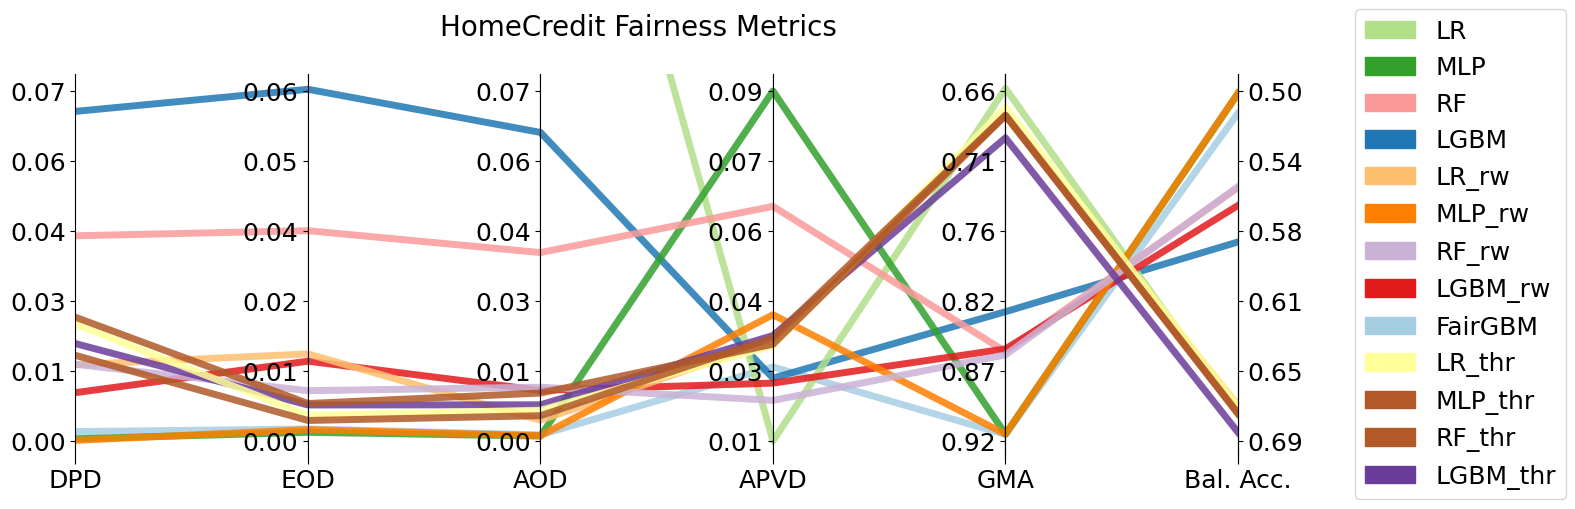

In [105]:
parallel_coordinates(
    df = df_metrics_test,
    columns = [
        'DPD',
        'EOD',
        'AOD',
        'APVD',
        'GMA',
        'balanced_accuracy',
    ],
    columns_ranges = [[0, 0.07], [0, 0.062], [0, 0.07], None, [0.92, 0.66], [0.69, 0.5]],
    columns_tick_format = columns_tick_format,
    columns_names = [
        'DPD',
        'EOD',
        'AOD',
        'APVD',
        'GMA',
        'Bal. Acc.',
    ],
    color_column = "model",
    color_mapper = None,
    name_mapper = name_mapper,
    legend_order = legends_order_hm,
    title = "HomeCredit Fairness Metrics"
)
plt.savefig("homecredit_fairness_metrics.pdf", bbox_inches = "tight", dpi=300)